In [ ]:
# Part 2:  Autonomous Car : vehicle detection 
# Task: AIML Capstone
# Task: Part1
# Developer: Soumen Dey, Date: July-2025
# License: BSD
# Develomenet tool: google colab
# technology: Yolov8 / https://yolov8.com/
#-------------------------------------------------------------------

# STEP 1 : Read RAR images ALL and Extract to local folder
# --------------------------------------------------------

import os
import requests
from google.colab import drive

# OPTIONAL: Mount Google Drive if you want to save files there
# drive.mount('/content/drive')

# === SETUP VARIABLES ===
# Replace with your actual file part URLs from GitHub
rar_parts = [
    "https://github.com/Rimbik/assessments/raw/refs/heads/main/gen-ai/capstone1/imgsrc/Images.part1.rar",
    "https://github.com/Rimbik/assessments/raw/refs/heads/main/gen-ai/capstone1/imgsrc/Images.part2.rar",
    "https://github.com/Rimbik/assessments/raw/refs/heads/main/gen-ai/capstone1/imgsrc/Images.part3.rar",
    "https://github.com/Rimbik/assessments/raw/refs/heads/main/gen-ai/capstone1/imgsrc/Images.part4.rar",
    "https://github.com/Rimbik/assessments/raw/refs/heads/main/gen-ai/capstone1/imgsrc/Images.part5.rar",
    "https://github.com/Rimbik/assessments/raw/refs/heads/main/gen-ai/capstone1/imgsrc/Images.part6.rar",
    "https://github.com/Rimbik/assessments/raw/refs/heads/main/gen-ai/capstone1/imgsrc/Images.part7.rar",
    "https://github.com/Rimbik/assessments/raw/refs/heads/main/gen-ai/capstone1/imgsrc/Images.part8.rar"

    # Add more parts if needed
]

output_dir = "/content/multifiles/extractedImg"  # Local folder in Colab
os.makedirs(output_dir, exist_ok=True)

# === DOWNLOAD RAR PARTS ===
for url in rar_parts:
    filename = url.split("/")[-1]
    filepath = os.path.join(output_dir, filename)
    print(f"Downloading {filename}...")
    with open(filepath, "wb") as f:
        f.write(requests.get(url).content)

# === INSTALL UNRAR TOOL ===
!apt-get install unrar -y

# === EXTRACT FILES ===
# Find the first .part1.rar file
main_rar = next((f for f in os.listdir(output_dir) if f.endswith(".part1.rar")), None)
if main_rar:
    main_rar_path = os.path.join(output_dir, main_rar)
    print("Extracting...")
    !unrar x -o+ "{main_rar_path}" "{output_dir}/"
    print("✅ Extraction complete.")
else:
    print("❌ .part1.rar file not found.")

In [ ]:
# Step 2: Install required libraries
!pip install ultralytics pandas opencv-python


In [ ]:
# STEP 2
# Create Yollov8 annotation fresh insteads of using existing annotations
#-----------------------------------------------------------------------

from ultralytics import YOLO
import os
import cv2
import pandas as pd

# --- CONFIGURE PATHS ---
image_dir       = '/content/multifiles/extractedImg/Images/'   # Folder containing .jpg images
csv_output_path = '/content/multifiles/annot/annotations.csv'        # Final output CSV

annotFolder = '/content/multifiles/annot'
os.makedirs(annotFolder, exist_ok=True)

# Load YOLOv8 pretrained model (use yolov8m.pt or custom model for better results)
model = YOLO('yolov8n.pt')

# Prepare data storage
annotations = []

# Loop through all .jpg images
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith('.jpg')]

for img_file in image_files:
    img_path = os.path.join(image_dir, img_file)
    img = cv2.imread(img_path)
    if img is None:
        print(f"❌ Could not read image: {img_path}")
        continue

    h, w = img.shape[:2]
    results = model(img_path)[0]

    for box in results.boxes:
        cls_id = int(box.cls[0])
        class_name = model.names[cls_id]

        # Get absolute xyxy format (x1, y1, x2, y2)
        x1, y1, x2, y2 = map(int, box.xyxy[0])

        # Append to annotation list
        annotations.append([os.path.splitext(img_file)[0], class_name, x1, y1, x2, y2])

# Create and save CSV
df = pd.DataFrame(annotations, columns=['filename', 'class_name', 'x1', 'y1', 'x2', 'y2'])
df.to_csv(csv_output_path, index=False)

print(f"✅ Annotation CSV created at: {csv_output_path}")

import shutil
import os
shutil.copy(csv_output_path, image_dir) # place the annotation.csv to image path

In [ ]:
# convert single CSV to individual .txt (as needed by yolo training time)
#------------------------------------------------------------------------

import os
import pandas as pd
import cv2

# --- CONFIGURATION ---
csv_path  = '/content/multifiles/annot/annotations.csv'  # Path to your CSV file
image_dir = '/content/multifiles/extractedImg/Images'    # Folder with all .jpg images
label_dir = '/content/multifiles/extractedImg/labels'    # Output folder for .txt files
os.makedirs(label_dir, exist_ok=True)

# Mapping from class name to ID (adjust as needed)
# class_map = {
#     'car': 0,
#     'truck': 1,
#     'pickup_truck': 2
# }

class_map = {
    'car': 2,
    'motorcycle': 3,
    'bus': 5,
    'truck': 7,
    'pickup_truck': 8,
    'bicycle': 1,
}


# Read CSV
df = pd.read_csv(csv_path, header=None, names=['filename', 'class', 'x1', 'y1', 'x2', 'y2'])

# Group by filename
for filename, group in df.groupby('filename'):
    file_str = str(filename).zfill(7)  # Ensures '0000001' format
    image_path = os.path.join(image_dir, file_str + '.jpg')
    label_path = os.path.join(label_dir, file_str + '.txt')

    if not os.path.exists(image_path):
        print(f"❌ Image not found: {image_path}")
        continue

    # Get image dimensions
    img = cv2.imread(image_path)
    if img is None:
        print(f"❌ Could not read image: {image_path}")
        continue
    h, w = img.shape[:2]

    # Write .txt file
    with open(label_path, 'w') as f:
        for _, row in group.iterrows():
            class_name = row['class'].strip().lower()
            class_id = class_map.get(class_name, -1)
            if class_id == -1:
                print(f"⚠️ Unknown class: {class_name}")
                continue

            x1, y1, x2, y2 = row[['x1', 'y1', 'x2', 'y2']].astype(float)
            x_center = (x1 + x2) / 2 / w
            y_center = (y1 + y2) / 2 / h
            bbox_w = (x2 - x1) / w
            bbox_h = (y2 - y1) / h

            f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_w:.6f} {bbox_h:.6f}\n")

print("✅ All YOLOv8 .txt label files created in:", label_dir)


In [ ]:
# step> 001
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Load pretrained or your custom model
model = YOLO('yolov8n.pt')  # replace with your trained model if needed

# Inference on images
image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.png'))]

for img_path in image_paths:
    results = model(img_path)[0]  # First image, first result
    boxes = results.boxes
    img = cv2.imread(img_path)

    for box in boxes:
        cls = int(box.cls[0])
        conf = float(box.conf[0])
        label = model.names[cls]

        # Bounding box
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, f"{label} {conf:.2f}", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    # Show the image with bounding boxes
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(img_path)
    plt.show()


In [ ]:
# set data 70:30 for Training and Validation
import os
import shutil
import random

# --- Setup ---
image_dir = '/content/multifiles/extractedImg/Images'
# label_dir = '/content/labels'  # optional, if using YOLO labels
output_dir = '/content/dataset'
train_ratio = 0.7

# Create destination folders
paths = [
    'images/train', 'images/val',
    'labels/train', 'labels/val'
]
for p in paths:
    os.makedirs(os.path.join(output_dir, p), exist_ok=True)

# Get image list
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith('.jpg')]
random.shuffle(image_files)

# Split
split_index = int(len(image_files) * train_ratio)
train_files = image_files[:split_index]
val_files = image_files[split_index:]

# Copy files
def copy_split(files, split_type):
    for file in files:
        base = os.path.splitext(file)[0]
        # Copy image
        shutil.copy(os.path.join(image_dir, file), os.path.join(output_dir, f'images/{split_type}', file))
        # Copy label if exists
        label_path = os.path.join(label_dir, base + '.txt')
        if os.path.exists(label_path):
            shutil.copy(label_path, os.path.join(output_dir, f'labels/{split_type}', base + '.txt'))

copy_split(train_files, 'train')
copy_split(val_files, 'val')

print(f"✅ Split complete: {len(train_files)} training and {len(val_files)} validation images.")


In [ ]:
# create data.yml file

data_yaml_path = '/content/multifiles/yaml'
os.makedirs(data_yaml_path, exist_ok=True)

# class_names = ['car', 'truck', 'pickup_truck']
class_names = ['car', 'motorcycle', 'bus','truck','pickup_truck','bicycle']
class_map = {
    'car': 2,
    'motorcycle': 3,
    'bus': 5,
    'truck': 7,
    'pickup_truck': 8,
    'bicycle': 1,
}

data_yaml_path = os.path.join(data_yaml_path, 'data.yaml')

with open(data_yaml_path, 'w') as f:
    f.write(f"path: /content/multifiles/extractedImg/Images\n")
    f.write(f"train: /content/dataset/images/train\n")
    f.write(f"val: /content/dataset/images/val\n")
    f.write("names:\n")
    for i, name in enumerate(class_names):
        f.write(f"  {i}: {name}\n")

print(f"✅ data.yaml created at {data_yaml_path}")




In [ ]:
# train the model
from ultralytics import YOLO

# Train a YOLOv8 model
data_yaml_path = '/content/multifiles/yaml/data.yaml'

model = YOLO('yolov8n.pt')  # start with pretrained nano model (or yolov8m.pt for better)
model.train(data=data_yaml_path, epochs=10, patience=3, imgsz=640)

model.save("bestYoloModel.pt")


In [ ]:
# Plot the training (val loss goes up if overfitting)
import pandas as pd
import matplotlib.pyplot as plt

# Path to YOLOv8 training log
csv_path = 'runs/detect/train11/results.csv'  # Update if needed

# Load training data
df = pd.read_csv(csv_path)

# Plot losses
plt.figure(figsize=(10, 6))
plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
plt.plot(df['epoch'], df['train/cls_loss'], label='Train Class Loss')
plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
plt.plot(df['epoch'], df['val/cls_loss'], label='Val Class Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('YOLOv8 Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



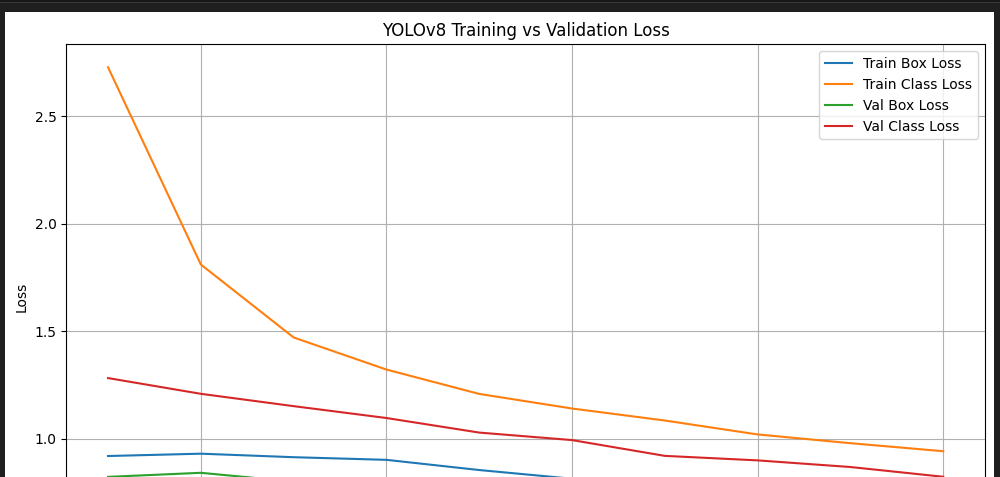

In [ ]:
# # plot accuracy
# plt.plot(df['epoch'], df['metrics/mAP_50'], label='mAP@50')
# plt.plot(df['epoch'], df['metrics/mAP_50-95'], label='mAP@50-95')
# plt.title('Validation Accuracy (mAP)')
# plt.xlabel('Epoch')
# plt.ylabel('mAP')
# plt.legend()
# plt.grid(True)
# plt.show()




image 1/1 /aa.jpg: 416x640 10 cars, 1 motorcycle, 9.7ms
Speed: 2.7ms preprocess, 9.7ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 640)


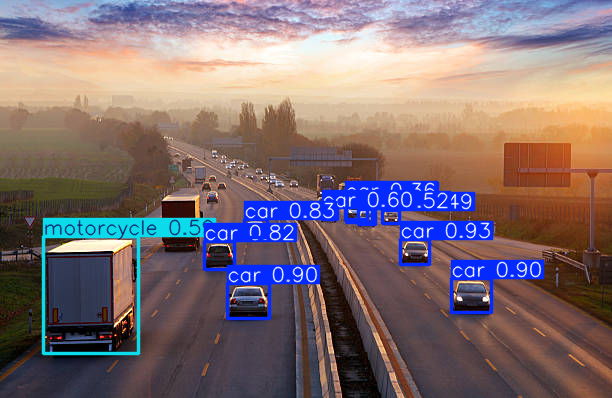

car: 0.93 at [400,239,429,264]
car: 0.90 at [227,283,269,318]
car: 0.90 at [451,278,491,312]
car: 0.83 at [244,219,267,237]
car: 0.82 at [204,241,234,269]
car: 0.60 at [322,208,337,219]
motorcycle: 0.59 at [43,236,138,353]
car: 0.52 at [358,209,375,224]
car: 0.49 at [382,210,399,223]
car: 0.36 at [345,199,367,219]
car: 0.32 at [346,200,372,222]


In [47]:
# inference

# Load your trained model
custom_model_path = '/content/bestYoloModel.pt'
model = YOLO(custom_model_path)

# Inference on a new image
# test_image = '/content/multifiles/extractedImg/Images/00000198.jpg'  # or any new image
test_image = '/aa.jpg'  # or any new image
results = model(test_image)

# Visualize result
results[0].show()  # Shows annotated image

# Save annotated image
results[0].save(filename='/content/predicted.jpg')

# Print predictions
for box in results[0].boxes:
    cls_id = int(box.cls[0])
    conf = float(box.conf[0])
    label = model.names[cls_id]
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    print(f"{label}: {conf:.2f} at [{x1},{y1},{x2},{y2}]")


